In [1]:
import pandas as pd
import numpy as np
import glob # 파일의 경로명을 이용하여 파일들의 리스트를 뽑을 때 사용

In [2]:
def one_hot_encoding(n, length):
    one_hot = [0] * length
    one_hot[n] = 1
    
    return one_hot

In [3]:
def rand_shuffle(data, label):

    s = np.arange(data.shape[0])
    np.random.shuffle(s)

    return data[s], label[s]

In [4]:
def make_valid(data, label):
    pivot = round(data.shape[0] * 0.9)
    train_data = data[:pivot]
    train_label = label[:pivot]
    
    test_data = data[pivot:]
    test_label = label[pivot:]
    
    return train_data, train_label, test_data, test_label

In [14]:
def read_db(path, nlabel):    
    data_temp = []
    data = []
    label = []
    
    filenames = glob.glob(path + '\\'+ "*.txt")

    for filename in filenames:

        f = open(filename, 'r', errors='ignore')
        lines = f.readlines()
        line = []
        line1 = []
        for i, d in enumerate(lines):
            tmp = lines[i].split(' ')

            line.extend(tmp)

            if i % 4 == 3:
                data_temp.append(line)
                line = []

        data.append(data_temp)
        label.append(one_hot_encoding(nlabel, 2))
        data_temp = []

    data = np.array(data, dtype='float32')
    label = np.array(label, dtype='float32')
    
    data = data/2000
    return data, label


In [15]:
#init
nbin = 40
nframe = 2000

In [16]:
#DB read
#1. None People
path = r'D:\study\DB\UWB\NonePeople'
data_nonepeople, label_nonepeople = read_db(path,0)

#2. People
path = r'D:\study\DB\UWB\People\MorePeople'
data_morepeople, label_morepeople = read_db(path,1)
path = r'D:\study\DB\UWB\People\OnePeople'
data_onepeople, label_onepeople = read_db(path,1)


data_nonepeople = data_nonepeople.reshape(data_nonepeople.shape[0],nframe,nbin,1)
data_morepeople = data_morepeople.reshape(data_morepeople.shape[0],nframe,nbin,1)
data_onepeople = data_onepeople.reshape(data_onepeople.shape[0],nframe,nbin,1)


print(data_nonepeople.shape)
print(data_morepeople.shape)
print(data_onepeople.shape)

print(label_nonepeople[0])
print(label_morepeople[0])
print(label_onepeople[0])

(1676, 2000, 40, 1)
(925, 2000, 40, 1)
(944, 2000, 40, 1)
[1. 0.]
[0. 1.]
[0. 1.]


In [17]:
# DB종류별 Train data(90%), Test Data(10%) 구분
data_nonepeople, label_nonepeople = rand_shuffle(data_nonepeople, label_nonepeople)
train_data_nonepeople, train_label_nonepeople, test_data_nonepeople, test_label_nonepeople, = make_valid(data_nonepeople, label_nonepeople)
data_morepeople, label_morepeople = rand_shuffle(data_morepeople, label_morepeople)
train_data_morepeople, train_label_morepeople, test_data_morepeople, test_label_morepeople, = make_valid(data_morepeople, label_morepeople)
data_onepeople, label_onepeople = rand_shuffle(data_onepeople, label_onepeople)
train_data_onepeople, train_label_onepeople, test_data_onepeople, test_label_onepeople, = make_valid(data_onepeople, label_onepeople)

print(train_data_nonepeople.shape)
print(train_data_morepeople.shape)
print(train_data_onepeople.shape)

print(test_data_nonepeople.shape)
print(test_data_morepeople.shape)
print(test_data_onepeople.shape)

(1508, 2000, 40, 1)
(832, 2000, 40, 1)
(850, 2000, 40, 1)
(168, 2000, 40, 1)
(93, 2000, 40, 1)
(94, 2000, 40, 1)


In [18]:
#DB 종류 병합하여, 하나의 rain_data vs Test_data 로 구분
train_data = np.concatenate((train_data_nonepeople, train_data_morepeople,train_data_onepeople), axis = 0)
test_data = np.concatenate((test_data_nonepeople, test_data_morepeople,test_data_onepeople), axis = 0)

train_label = np.concatenate((train_label_nonepeople, train_label_morepeople,train_label_onepeople), axis = 0)
test_label = np.concatenate((test_label_nonepeople, test_label_morepeople,test_label_onepeople), axis = 0)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(3190, 2000, 40, 1)
(3190, 2)
(355, 2000, 40, 1)
(355, 2)


In [19]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Conv2D(filters=4, kernel_size = 3, padding = 'same', activation='relu', input_shape=(nframe, nbin, 1)))#nframe = 2000, nbin=40
model.add(layers.MaxPooling2D( pool_size=(10, 2) ))
model.add(layers.Conv2D(filters=8, kernel_size = 3, padding = 'same', activation='relu'))
model.add(layers.MaxPooling2D( pool_size=(10, 2) ))
model.add(layers.Conv2D(filters=8, kernel_size = 3, padding = 'same', activation='relu'))
model.add(layers.MaxPooling2D( pool_size=(10, 2) ))
model.add(layers.Conv2D(filters=16, kernel_size = 3, padding = 'same', activation='relu'))
model.add(layers.MaxPooling2D( pool_size=(2, 2) ))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 2000, 40, 4)       40        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 200, 20, 4)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 200, 20, 8)        296       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 10, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 10, 8)         584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 5, 8)           0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 5, 16)         

In [20]:
from tensorflow.keras import optimizers

model.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history = model.fit(train_data, 
                    train_label,
                    validation_split = 0.1,
                    shuffle=True,
                    epochs=10,
                    batch_size=10)

Epoch 1/10
288/288 [==============================] - 15s 52ms/step - loss: 0.4276 - accuracy: 0.8008 - val_loss: 0.3788 - val_accuracy: 0.7712
Epoch 2/10
288/288 [==============================] - 16s 54ms/step - loss: 0.2669 - accuracy: 0.8997 - val_loss: 0.3166 - val_accuracy: 0.8370
Epoch 3/10
288/288 [==============================] - 15s 52ms/step - loss: 0.2352 - accuracy: 0.9126 - val_loss: 0.5188 - val_accuracy: 0.7680
Epoch 4/10
288/288 [==============================] - 15s 53ms/step - loss: 0.2153 - accuracy: 0.9202 - val_loss: 0.2087 - val_accuracy: 0.9028
Epoch 5/10
288/288 [==============================] - 15s 54ms/step - loss: 0.2114 - accuracy: 0.9199 - val_loss: 0.2190 - val_accuracy: 0.8871
Epoch 6/10
288/288 [==============================] - 15s 53ms/step - loss: 0.1998 - accuracy: 0.9258 - val_loss: 0.3003 - val_accuracy: 0.8652
Epoch 7/10
288/288 [==============================] - 15s 53ms/step - loss: 0.1973 - accuracy: 0.9265 - val_loss: 0.4058 - val_accuracy:

In [ ]:
results = model.evaluate(test_data_nonepeople, test_label_nonepeople)
print('NonePeopel => ', results)
results = model.evaluate(test_data_onepeople, test_label_onepeople)
print('OnePeopel => ', results)
results = model.evaluate(test_data_morepeople, test_label_morepeople)
print('MorePeopel => ', results)

print()
results = model.evaluate(test_data, test_label)
print('Total => ', results)

In [ ]:
tflite_model_name = 'UWBedge_model_ver1'
model.save(tflite_model_name + '.h5')

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open('UWBedge_model_ver1' +'.tflite','wb').write(tflite_model)

In [ ]:
predictions = model.predict_classes(test_data_nonepeople)
predictions

In [ ]:
history_dict = history.history
history_dict.keys()

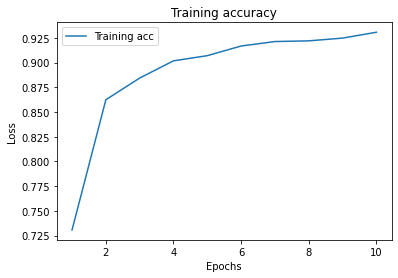

In [19]:
import matplotlib.pyplot as plt

plt.clf()
acc_values = history_dict['accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, acc_values, label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

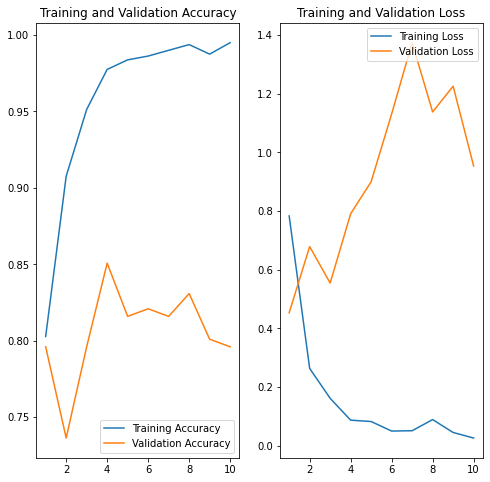

In [265]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()